# Demo Notebook
This notebook is to demonstrate the different classes and functions in the ipp_library.py file found in this repository. 

In [1]:
# Imports
from matplotlib import pyplot as plt
import matplotlib
from matplotlib.colors import LogNorm
from matplotlib import cm
from sklearn import mixture
from IPython.display import display
from scipy.stats import multivariate_normal
import numpy as np
import scipy as sp
import math
import os
import GPy as GPy
import dubins
import time
from itertools import chain

In [35]:
from ipp_library import *

In [36]:
%matplotlib inline
%load_ext autoreload
%aimport ipp_library
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


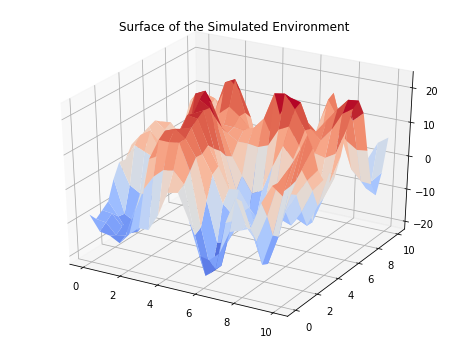

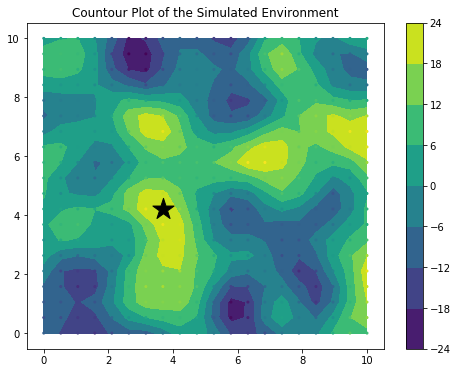

Environment initialized with bounds X1: ( 0.0 , 10.0 )  X2:( 0.0 , 10.0 )
[ 0 ] Current Location:   (5.0, 5.0, 0.0)
Starting global maximization, sampling: 500
Max val in optmization 	 	[69.10861045]
Starting global maximization, sampling: 500
Max val in optmization 	 	[78.59343427]


 ipp_library.py:520: RuntimeWarning:divide by zero encountered in log
 ipp_library.py:520: RuntimeWarning:invalid value encountered in sqrt
 ipp_library.py:520: RuntimeWarning:invalid value encountered in double_scalars
 ipp_library.py:520: RuntimeWarning:divide by zero encountered in double_scalars


Number of rollouts: 1350 	 Size of tree: 2888


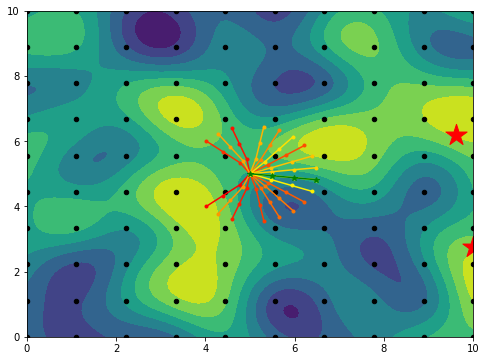

[ 1 ] Current Location:   (6.48852244946592, 4.814948690246519, 6.159194011658301)
Starting global maximization, sampling: 500
Max val in optmization 	 	[37.64259727]
Starting global maximization, sampling: 500
Max val in optmization 	 	[42.053181]
Number of rollouts: 1365 	 Size of tree: 2930


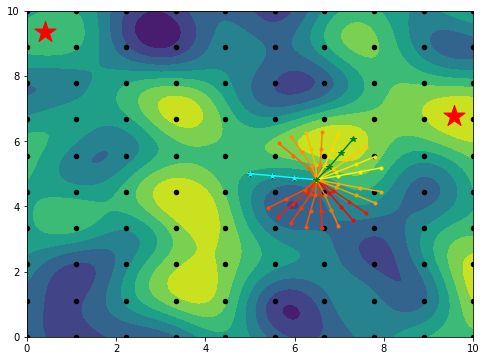

[ 2 ] Current Location:   (7.305513815499852, 6.056986832177973, 1.0123424987459142)
Starting global maximization, sampling: 500
Max val in optmization 	 	[42.05796633]
Starting global maximization, sampling: 500
Max val in optmization 	 	[39.22591161]
Number of rollouts: 1348 	 Size of tree: 2882


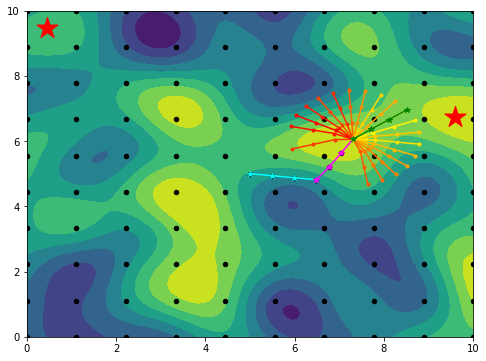

[ 3 ] Current Location:   (8.507089208399373, 6.954025205413105, 0.6385273488918073)
Starting global maximization, sampling: 500
Max val in optmization 	 	[35.09025437]
Starting global maximization, sampling: 500
Max val in optmization 	 	[24.172872]
Number of rollouts: 1404 	 Size of tree: 1176


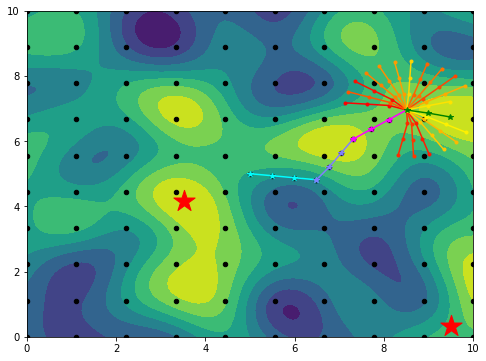

[ 4 ] Current Location:   (9.47793551059156, 6.741776777157029, 6.046251542325577)
Starting global maximization, sampling: 500
Max val in optmization 	 	[31.30897736]
Starting global maximization, sampling: 500
Max val in optmization 	 	[24.81339197]
Number of rollouts: 1435 	 Size of tree: 1096


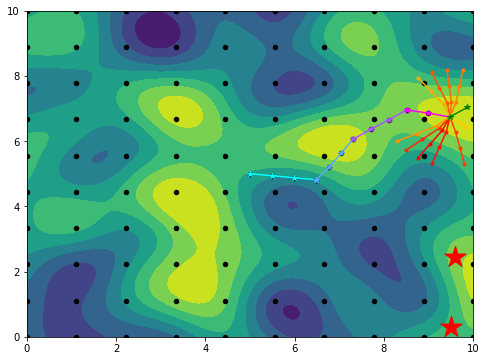

[ 5 ] Current Location:   (9.869591063894013, 7.040702665060649, -0.43823313908010175)
Starting global maximization, sampling: 500
Max val in optmization 	 	[32.25933313]
Starting global maximization, sampling: 500
Max val in optmization 	 	[25.44717037]
Number of rollouts: 1371 	 Size of tree: 1663


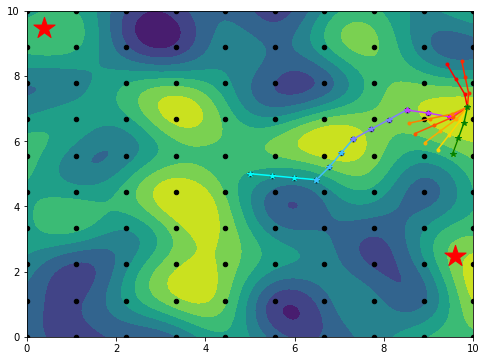

[ 6 ] Current Location:   (9.536692147818428, 5.602449691393227, 3.3114529224721263)
Starting global maximization, sampling: 500
Max val in optmization 	 	[34.20742951]
Starting global maximization, sampling: 500
Max val in optmization 	 	[24.85890493]
Number of rollouts: 1363 	 Size of tree: 1824


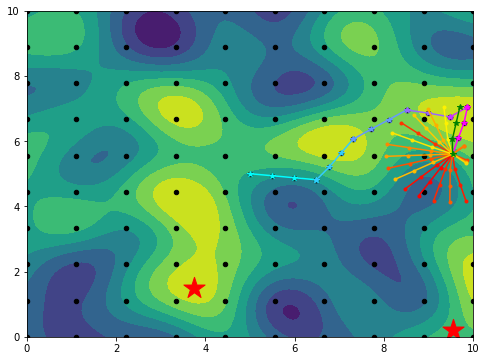

[ 7 ] Current Location:   (9.698987054572976, 7.037606127809733, 0.2628508845046764)
Starting global maximization, sampling: 500
Max val in optmization 	 	[35.41914215]
Starting global maximization, sampling: 500
Max val in optmization 	 	[24.59545857]
Number of rollouts: 1389 	 Size of tree: 1807


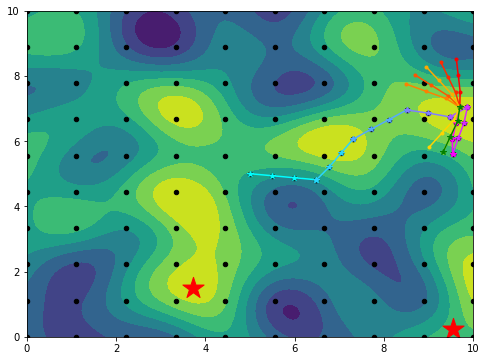

[ 8 ] Current Location:   (9.325395428937602, 5.664643342718667, 4.380886837980739)
Starting global maximization, sampling: 500
Max val in optmization 	 	[36.12580621]
Starting global maximization, sampling: 500
Max val in optmization 	 	[24.54848295]
Number of rollouts: 1291 	 Size of tree: 2439


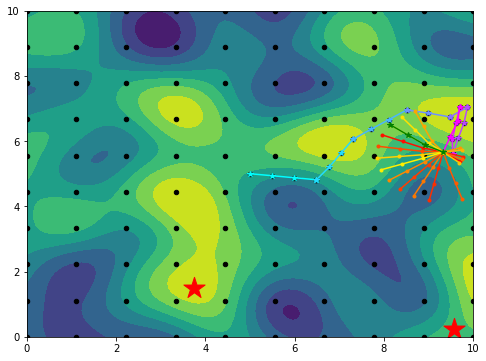

[ 9 ] Current Location:   (8.144868038529971, 6.496730305868275, 2.4722848000132895)
Starting global maximization, sampling: 500
Max val in optmization 	 	[36.20756853]
Starting global maximization, sampling: 500
Max val in optmization 	 	[25.32358442]
Number of rollouts: 1311 	 Size of tree: 1693


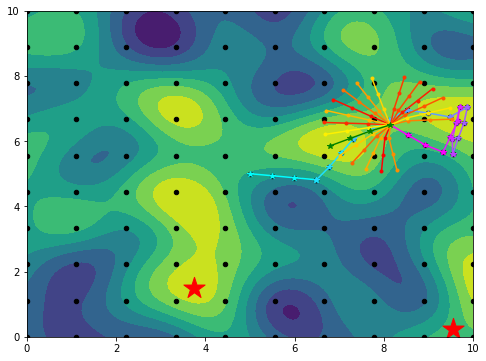

[ 10 ] Current Location:   (6.802139309944062, 5.858597718064928, 3.6086185942804887)
Starting global maximization, sampling: 500
Max val in optmization 	 	[36.38000761]
Starting global maximization, sampling: 500
Max val in optmization 	 	[24.7424781]
Number of rollouts: 1307 	 Size of tree: 2229


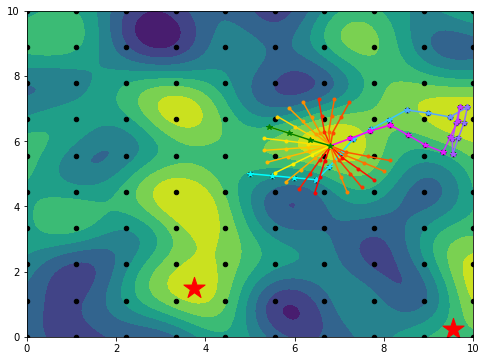

[ 11 ] Current Location:   (5.425694233261298, 6.43845016181541, 2.728300629806363)
Starting global maximization, sampling: 500
Max val in optmization 	 	[35.11356936]
Starting global maximization, sampling: 500
Max val in optmization 	 	[24.79049763]
Number of rollouts: 1311 	 Size of tree: 2072


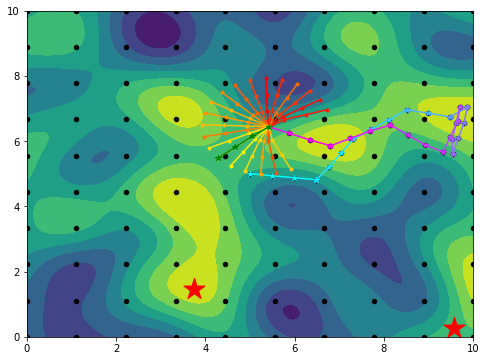

[ 12 ] Current Location:   (4.288322860085513, 5.481099652510299, 3.864634424073562)
Starting global maximization, sampling: 500
Max val in optmization 	 	[35.6486976]
Starting global maximization, sampling: 500
Max val in optmization 	 	[24.99047277]
Number of rollouts: 1311 	 Size of tree: 1559


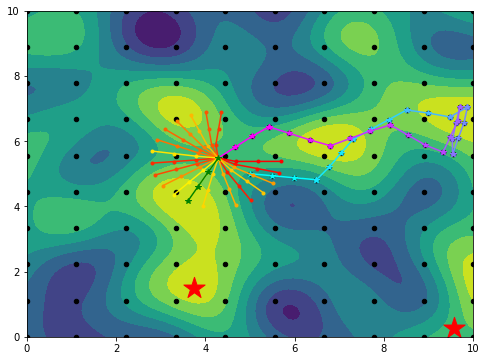

[ 13 ] Current Location:   (3.6002802542638124, 4.1487863858751375, 4.238449573927667)
Starting global maximization, sampling: 500
Max val in optmization 	 	[35.86899461]
Starting global maximization, sampling: 500
Max val in optmization 	 	[26.24993689]
Number of rollouts: 1268 	 Size of tree: 1739


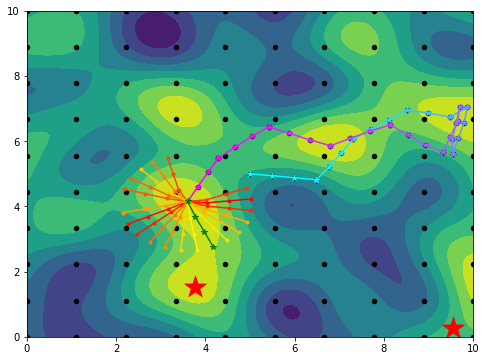

[ 14 ] Current Location:   (4.1706029106406675, 2.7683654452664865, 5.118767538401793)
Starting global maximization, sampling: 500
Max val in optmization 	 	[30.03334681]
Starting global maximization, sampling: 500
Max val in optmization 	 	[27.98702746]
Number of rollouts: 1298 	 Size of tree: 1563


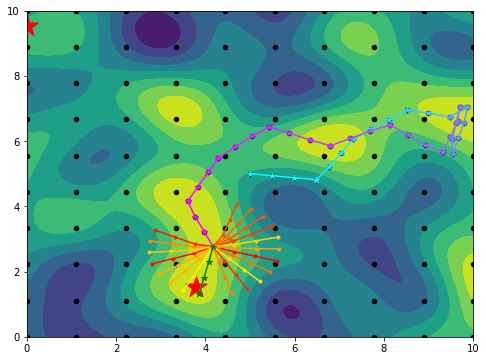

[ 15 ] Current Location:   (3.855430295045959, 1.3042668699390414, 4.492760194531968)
Starting global maximization, sampling: 500
Max val in optmization 	 	[36.08076058]
Starting global maximization, sampling: 500
Max val in optmization 	 	[28.10452591]
Number of rollouts: 1316 	 Size of tree: 2653


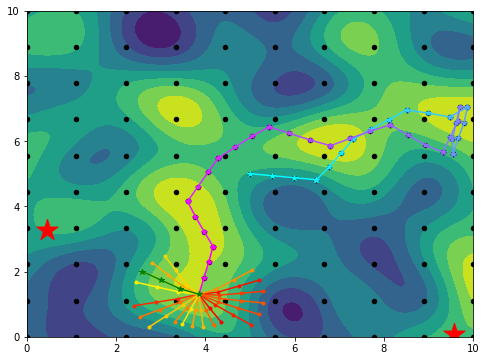

[ 16 ] Current Location:   (2.589388429326347, 1.9993579632436498, 2.584158156564518)
Starting global maximization, sampling: 500
Max val in optmization 	 	[32.33247286]
Starting global maximization, sampling: 500
Max val in optmization 	 	[34.36036749]
no viable path
Number of rollouts: 1323 	 Size of tree: 2781


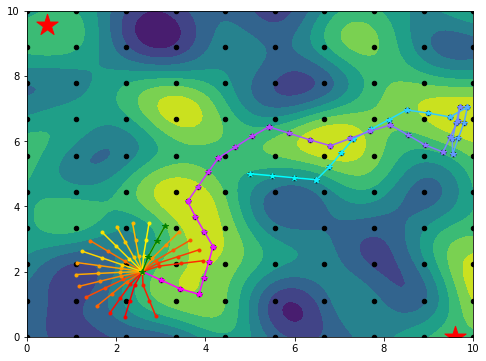

[ 17 ] Current Location:   (3.0909610645751395, 3.3878168917529026, 1.1906589109371606)
Starting global maximization, sampling: 500
Max val in optmization 	 	[34.46889722]
Starting global maximization, sampling: 500
Max val in optmization 	 	[39.41586732]
Number of rollouts: 1290 	 Size of tree: 2804


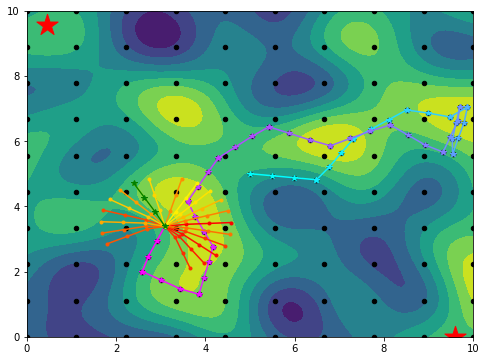

[ 18 ] Current Location:   (2.3938492222374883, 4.70875026816529, 2.0709768754112865)
Starting global maximization, sampling: 500
Max val in optmization 	 	[33.99662276]
Starting global maximization, sampling: 500
Max val in optmization 	 	[44.43959709]
Number of rollouts: 1318 	 Size of tree: 2808


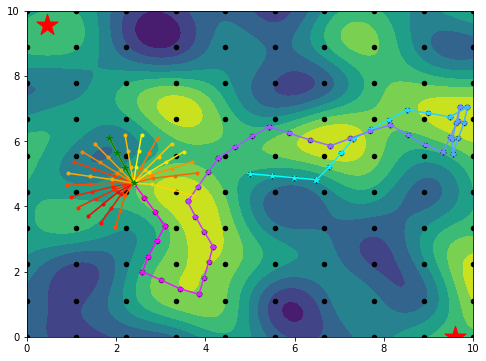

[ 19 ] Current Location:   (1.842359487787431, 6.103670388674599, 1.9469855798900007)
Starting global maximization, sampling: 500
Max val in optmization 	 	[35.02355566]
Starting global maximization, sampling: 500
Max val in optmization 	 	[32.17123691]
Number of rollouts: 1319 	 Size of tree: 2728


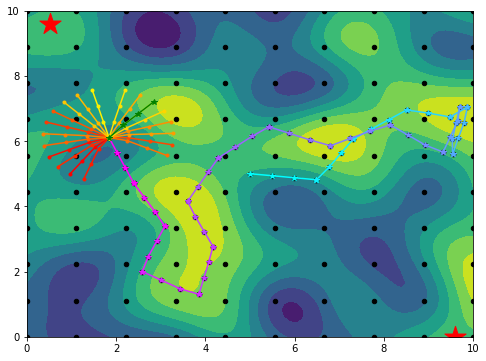

[ 20 ] Current Location:   (2.84124106866481, 7.204746782741077, 0.8106517856228013)
Starting global maximization, sampling: 500
Max val in optmization 	 	[35.27161296]
Starting global maximization, sampling: 500
Max val in optmization 	 	[30.11392467]
Number of rollouts: 1303 	 Size of tree: 2770


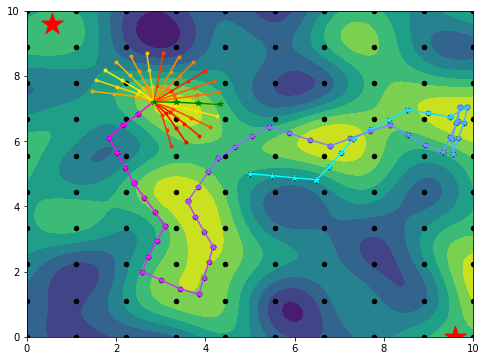

[ 21 ] Current Location:   (4.332572329937371, 7.122521635743213, 6.2135191283282625)
Starting global maximization, sampling: 500
Max val in optmization 	 	[35.21347618]
Starting global maximization, sampling: 500
Max val in optmization 	 	[30.56322466]
Number of rollouts: 1276 	 Size of tree: 2793


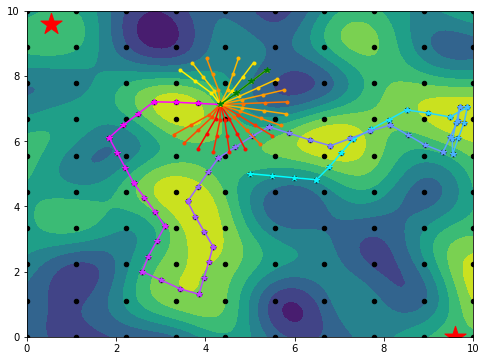

[ 22 ] Current Location:   (5.377378686848948, 8.189859249717715, 0.8106517856228006)
Starting global maximization, sampling: 500
Max val in optmization 	 	[34.95323822]
Starting global maximization, sampling: 500
Max val in optmization 	 	[29.98982418]
Number of rollouts: 1301 	 Size of tree: 2677


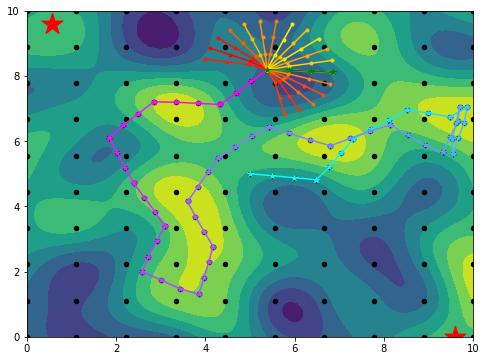

[ 23 ] Current Location:   (6.8687099481215075, 8.10763410271985, 6.213519128328262)
Starting global maximization, sampling: 500
Max val in optmization 	 	[36.45491204]
Starting global maximization, sampling: 500
Max val in optmization 	 	[27.78390136]
no viable path
no viable path
no viable path
Number of rollouts: 1303 	 Size of tree: 2692


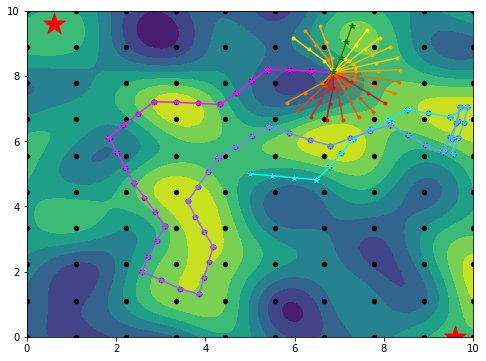

[ 24 ] Current Location:   (7.277317495351915, 9.526236646399308, 1.3238330667760323)
Starting global maximization, sampling: 500
Max val in optmization 	 	[37.42382101]
Starting global maximization, sampling: 500
Max val in optmization 	 	[27.09452549]
no viable path
no viable path
no viable path
no viable path
no viable path
no viable path
no viable path
no viable path
no viable path
no viable path
no viable path
Number of rollouts: 1297 	 Size of tree: 2214


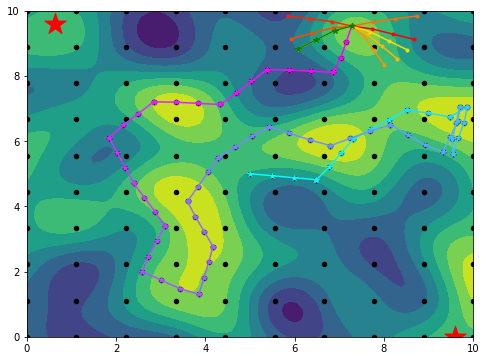

[ 25 ] Current Location:   (6.068847394852414, 8.822653907511304, 3.744024425400146)
Starting global maximization, sampling: 500
Max val in optmization 	 	[37.20327097]
Starting global maximization, sampling: 500
Max val in optmization 	 	[26.86867428]
Number of rollouts: 1278 	 Size of tree: 2620


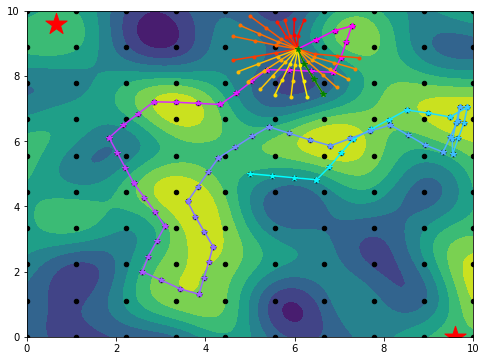

[ 26 ] Current Location:   (6.632368121667392, 7.45816217245484, 5.137523671027504)
Starting global maximization, sampling: 500
Max val in optmization 	 	[37.21241594]
Starting global maximization, sampling: 500
Max val in optmization 	 	[26.82598074]
Number of rollouts: 1287 	 Size of tree: 2767


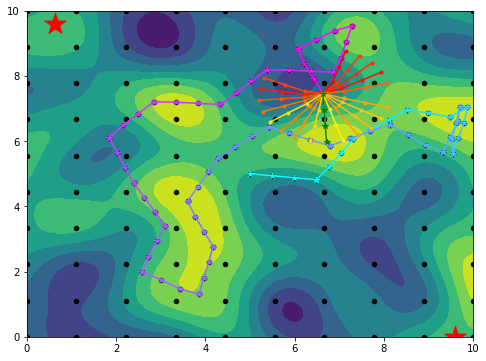

[ 27 ] Current Location:   (6.7134251263092075, 5.96086760227953, 4.763708521173397)
Starting global maximization, sampling: 500
Max val in optmization 	 	[37.12577216]
Starting global maximization, sampling: 500
Max val in optmization 	 	[27.05242245]
Number of rollouts: 1283 	 Size of tree: 2787


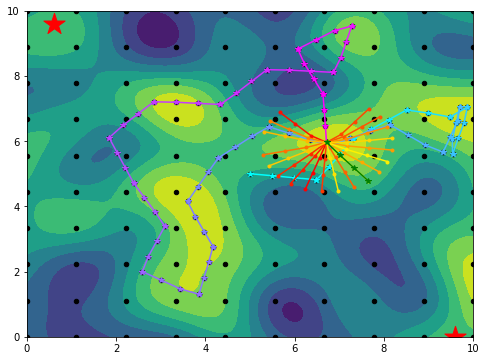

[ 28 ] Current Location:   (7.643119856065881, 4.786735529061474, 5.389715865043223)
Starting global maximization, sampling: 500
Max val in optmization 	 	[38.50139141]
Starting global maximization, sampling: 500
Max val in optmization 	 	[27.14449917]
Number of rollouts: 1293 	 Size of tree: 2746


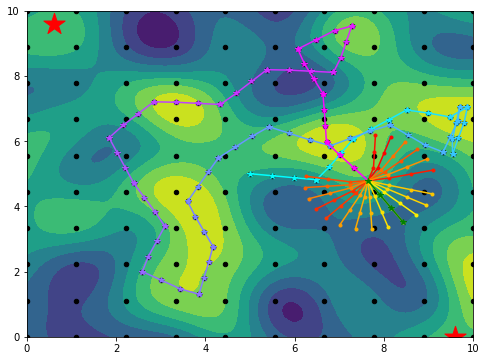

[ 29 ] Current Location:   (8.43179371574588, 3.510829336246753, 5.265724569521937)
Starting global maximization, sampling: 500
Max val in optmization 	 	[38.08617529]
Starting global maximization, sampling: 500
Max val in optmization 	 	[28.04330488]
Number of rollouts: 1301 	 Size of tree: 2646


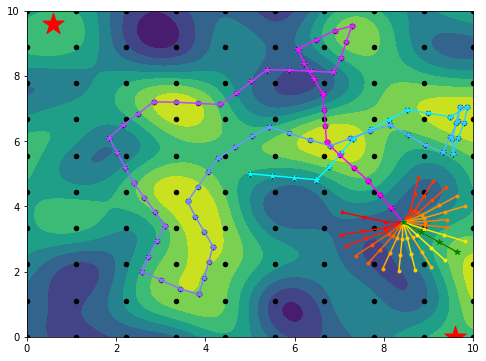

[ 30 ] Current Location:   (9.628762133561708, 2.6076527894800403, 4.499539719376044)
Starting global maximization, sampling: 500
Max val in optmization 	 	[41.17791129]
Starting global maximization, sampling: 500
Max val in optmization 	 	[27.97341837]
no viable path
no viable path
no viable path
no viable path
no viable path
no viable path
Number of rollouts: 1303 	 Size of tree: 2324


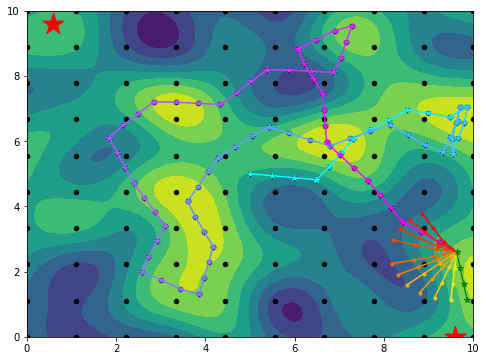

[ 31 ] Current Location:   (9.864996543483924, 1.1268913058349959, 3.7333548692301504)
Starting global maximization, sampling: 500
Max val in optmization 	 	[30.57882999]
Starting global maximization, sampling: 500
Max val in optmization 	 	[25.50524805]
Number of rollouts: 1307 	 Size of tree: 2313


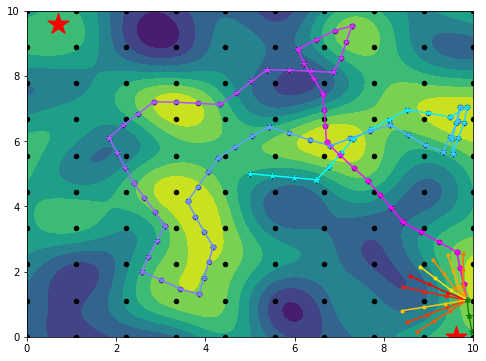

[ 32 ] Current Location:   (9.976939790548837, 0.14611010543557268, 3.720745898872644)
Starting global maximization, sampling: 500
Max val in optmization 	 	[31.65065307]
Starting global maximization, sampling: 500
Max val in optmization 	 	[25.26812911]
Number of rollouts: 1311 	 Size of tree: 2024


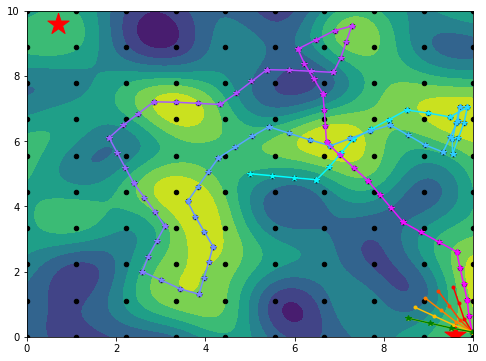

[ 33 ] Current Location:   (8.544257213792163, 0.5683073814872787, 2.8404279343985186)
Starting global maximization, sampling: 500
Max val in optmization 	 	[26.62587996]
Starting global maximization, sampling: 500
Max val in optmization 	 	[24.38946474]
Number of rollouts: 1292 	 Size of tree: 2416


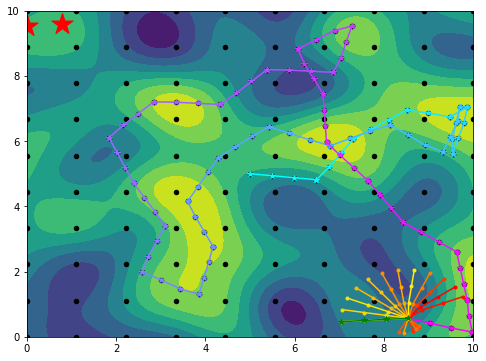

[ 34 ] Current Location:   (7.04843062636259, 0.4635978393396317, 2.0742430842526263)
Starting global maximization, sampling: 500
Max val in optmization 	 	[24.04659226]
Starting global maximization, sampling: 500
Max val in optmization 	 	[23.92285598]
no viable path
Number of rollouts: 1284 	 Size of tree: 2609


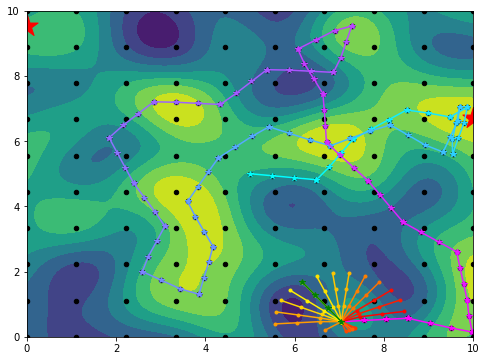

[ 35 ] Current Location:   (6.1682056454543135, 1.678154158655671, 2.1982343797739112)
Starting global maximization, sampling: 500
Max val in optmization 	 	[24.01101336]
Starting global maximization, sampling: 500
Max val in optmization 	 	[23.93335864]
Number of rollouts: 1262 	 Size of tree: 2119


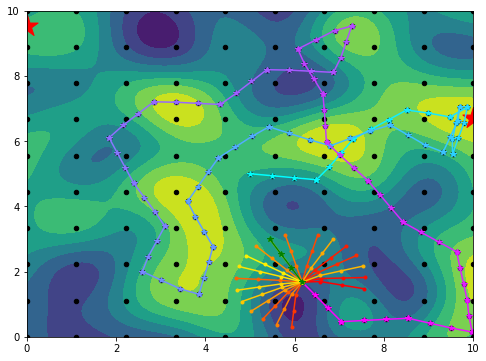

[ 36 ] Current Location:   (5.444140113753829, 2.991802580269611, 2.0742430842526254)
Starting global maximization, sampling: 500
Max val in optmization 	 	[25.88363972]
Starting global maximization, sampling: 500
Max val in optmization 	 	[23.92850463]
Number of rollouts: 1257 	 Size of tree: 2015


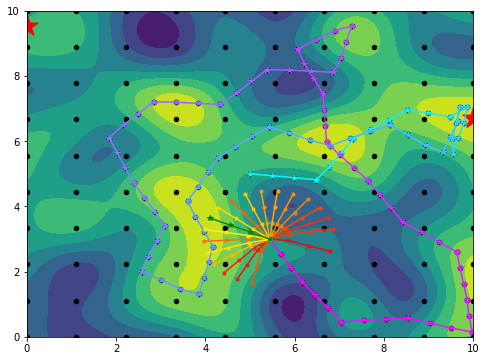

[ 37 ] Current Location:   (4.094906482693084, 3.6417925992016724, 2.700250428122451)
Starting global maximization, sampling: 500
Max val in optmization 	 	[26.09111567]
Starting global maximization, sampling: 500
Max val in optmization 	 	[24.03124341]
Number of rollouts: 1263 	 Size of tree: 1492


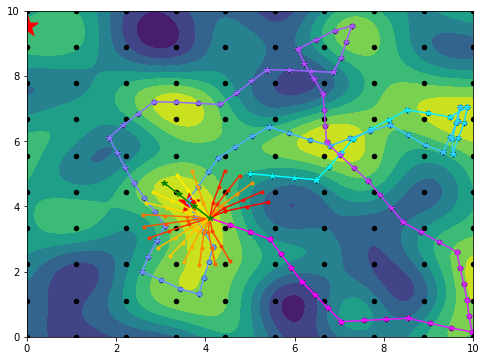

[ 38 ] Current Location:   (3.063615601218393, 4.730323896714577, 2.3264352782683444)
Starting global maximization, sampling: 500
Max val in optmization 	 	[24.24605556]
Starting global maximization, sampling: 500
Max val in optmization 	 	[24.24599334]
Number of rollouts: 1242 	 Size of tree: 1994


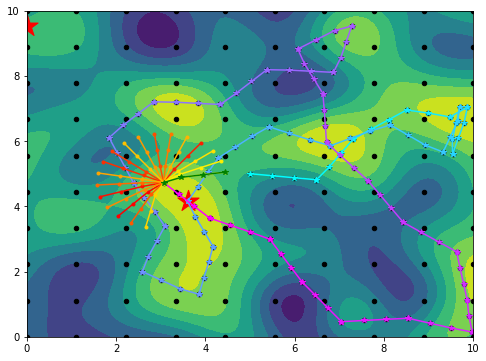

[ 39 ] Current Location:   (4.449959802212422, 5.050710020571598, 0.16128592456482016)
Starting global maximization, sampling: 500
Max val in optmization 	 	[23.82482027]
Starting global maximization, sampling: 500
Max val in optmization 	 	[24.29651846]
Number of rollouts: 1255 	 Size of tree: 1541


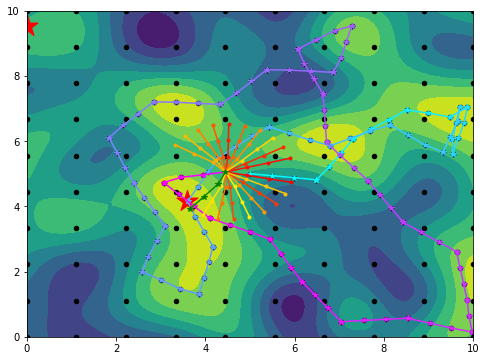

[ 40 ] Current Location:   (3.6455459736855507, 3.906880030259593, 4.0242798731202925)
Starting global maximization, sampling: 500
Max val in optmization 	 	[23.8859434]
Starting global maximization, sampling: 500
Max val in optmization 	 	[24.18466317]
Number of rollouts: 1256 	 Size of tree: 1584


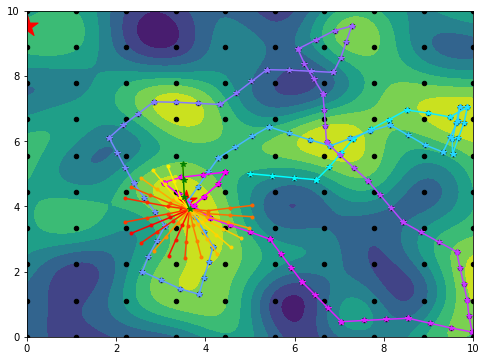

[ 41 ] Current Location:   (3.4941367840126243, 5.297025314589619, 1.6040885144961785)
Starting global maximization, sampling: 500
Max val in optmization 	 	[23.8273552]
Starting global maximization, sampling: 500
Max val in optmization 	 	[24.10804878]
Number of rollouts: 1250 	 Size of tree: 1571


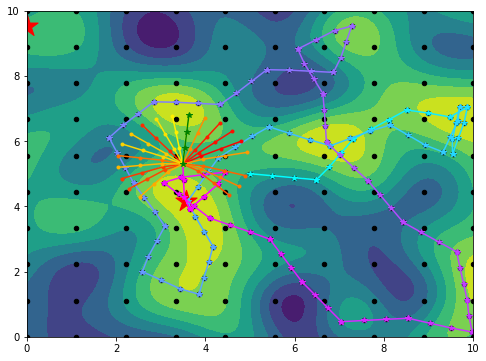

[ 42 ] Current Location:   (3.629538535733872, 6.790882548543492, 1.4800972189748927)
Starting global maximization, sampling: 500
Max val in optmization 	 	[23.6737616]
Max observed is bigger than max in opt: [23.70183287]
Starting global maximization, sampling: 500
Max val in optmization 	 	[24.11418985]
no viable path
no viable path
no viable path
Number of rollouts: 1229 	 Size of tree: 1835


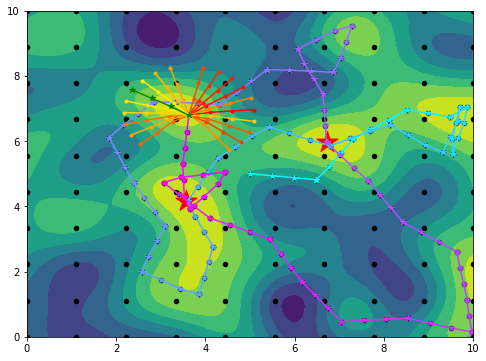

[ 43 ] Current Location:   (2.3609942433061413, 7.566078663301272, 2.616431013242092)
Starting global maximization, sampling: 500
Max val in optmization 	 	[23.67059696]
Max observed is bigger than max in opt: [23.70183287]
Starting global maximization, sampling: 500
Max val in optmization 	 	[24.11759196]
no viable path
no viable path
no viable path
Number of rollouts: 1196 	 Size of tree: 2307


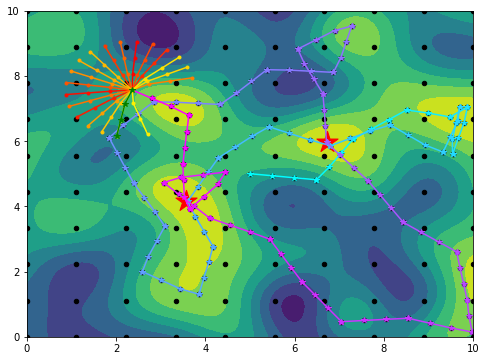

[ 44 ] Current Location:   (2.0139004112547676, 6.164101664382215, 4.52503305120954)
Starting global maximization, sampling: 500
Max val in optmization 	 	[23.72408774]
Starting global maximization, sampling: 500
Max val in optmization 	 	[24.11297374]
Number of rollouts: 1228 	 Size of tree: 1646


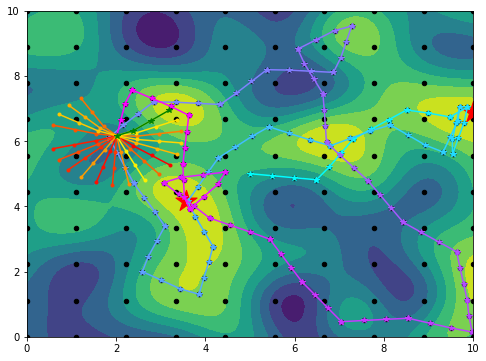

[ 45 ] Current Location:   (3.1783104211517115, 6.938425874977633, 0.6620391026540675)
Starting global maximization, sampling: 500
Max val in optmization 	 	[23.72410541]
Starting global maximization, sampling: 500
Max val in optmization 	 	[24.11016887]
Number of rollouts: 1233 	 Size of tree: 2263


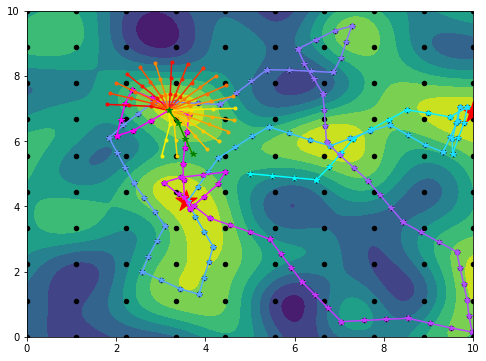

[ 46 ] Current Location:   (3.7134582447913544, 5.596922822204385, 5.036622371866204)
Starting global maximization, sampling: 500
Max val in optmization 	 	[23.72085528]
Starting global maximization, sampling: 500
Max val in optmization 	 	[24.1128189]
Number of rollouts: 1232 	 Size of tree: 1489


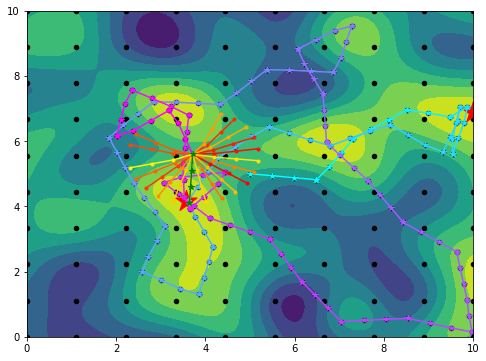

[ 47 ] Current Location:   (3.643280235605507, 4.099078933508142, 4.6628072220120975)
Starting global maximization, sampling: 500
Max val in optmization 	 	[23.72376441]
Starting global maximization, sampling: 500
Max val in optmization 	 	[24.04879891]
Number of rollouts: 1230 	 Size of tree: 1565


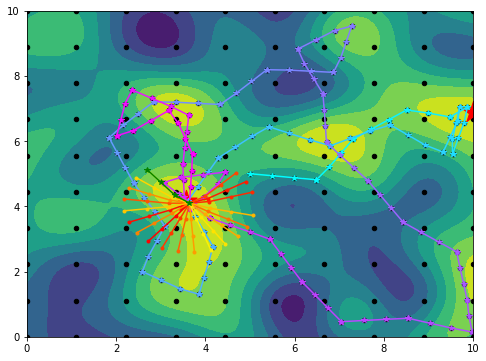

[ 48 ] Current Location:   (2.6931570628114945, 5.125088003050053, 2.2426158633879836)
Starting global maximization, sampling: 500
Max val in optmization 	 	[23.72778767]
Starting global maximization, sampling: 500
Max val in optmization 	 	[24.039994]
Number of rollouts: 1210 	 Size of tree: 1847


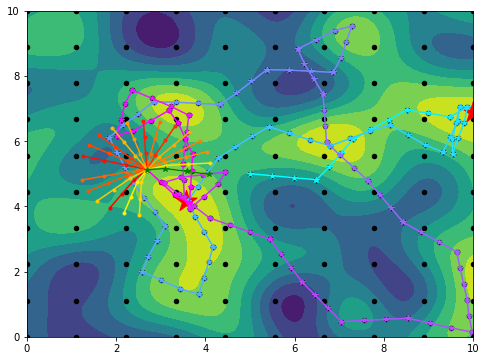

[ 49 ] Current Location:   (4.08420139122087, 4.982174285505065, 6.105609811943456)
Starting global maximization, sampling: 500
Max val in optmization 	 	[23.73771759]
Starting global maximization, sampling: 500
Max val in optmization 	 	[24.024286]
Number of rollouts: 1197 	 Size of tree: 1874


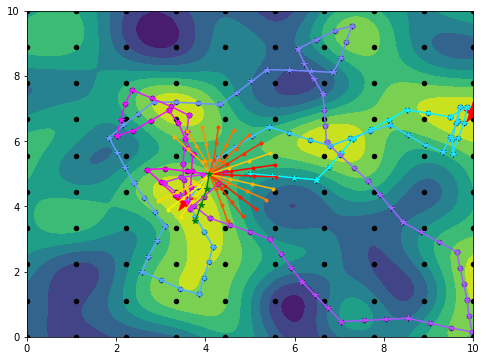

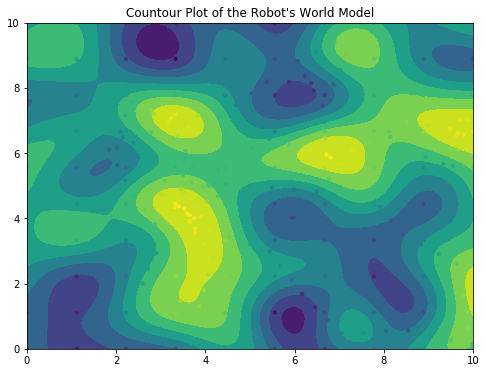

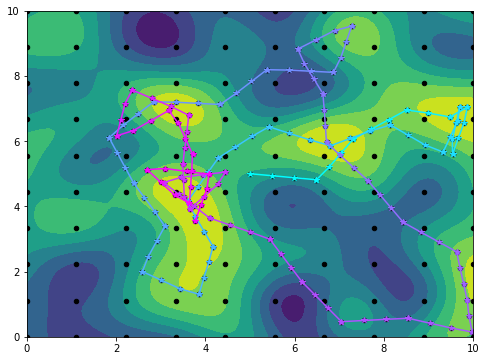

 ipp_library.py:1084: RuntimeWarning:divide by zero encountered in divide


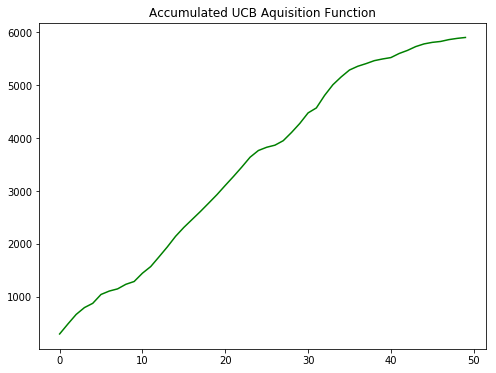

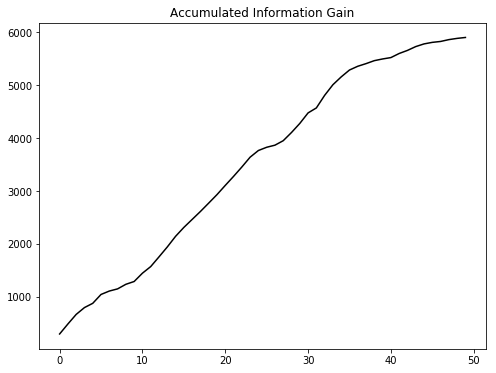

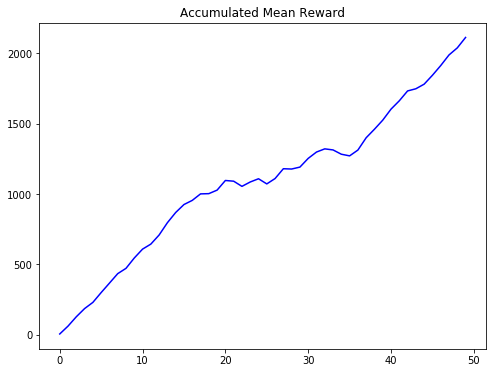

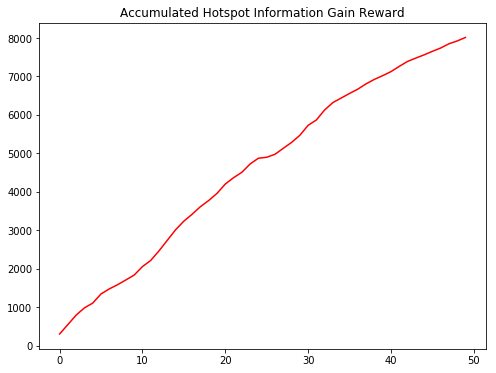

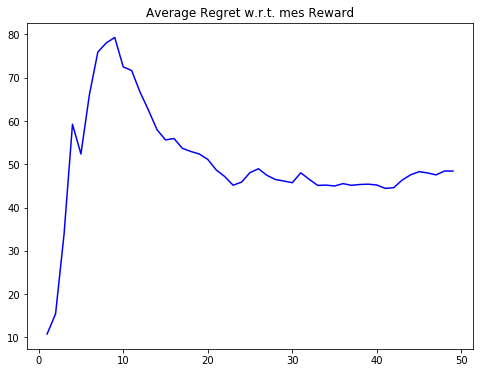

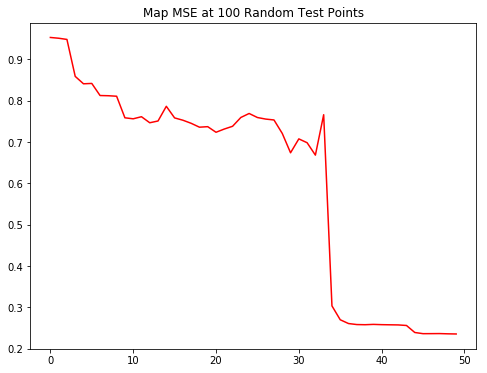

In [37]:
# Create a random enviroment sampled from a GP with an RBF kernel and specified hyperparameters, mean function 0 
# The enviorment will be constrained by a set of uniformly distributed  sample points of size NUM_PTS x NUM_PTS
''' Options include mean, info_gain, hotspot_info, and mes'''
reward_function = 'mes'
ranges = (0., 10., 0., 10.)

world = Environment(ranges = ranges, # x1min, x1max, x2min, x2max constraints
                    NUM_PTS = 20, 
                    variance = 100.0, 
                    lengthscale = 1.0, 
                    visualize = True,
                    seed = 1000)

evaluation = Evaluation(world = world, 
                        reward_function = reward_function)

# Gather some prior observations to train the kernel (optional)
#x1observe = np.linspace(ranges[0]+0.5, ranges[1]-0,5, 15)
#x2observe = np.linspace(ranges[2]+0.5, ranges[3]-0.5, 15)
x1observe = np.linspace(0., 10., 10)
x2observe = np.linspace(0., 10., 10)
x1observe, x2observe = np.meshgrid(x1observe, x2observe, sparse = False, indexing = 'xy')  
data = np.vstack([x1observe.ravel(), x2observe.ravel()]).T
observations = world.sample_value(data)

# Create the point robot
robot = Nonmyopic_Robot(sample_world = world.sample_value, 
              start_loc = (5.0, 5.0, 0.0), 
              extent = ranges,
              kernel_file = None,
              kernel_dataset = None,
              #prior_dataset =  None, 
              prior_dataset =  (data, observations), 
              init_lengthscale = 1.0, 
              init_variance = 100.0, 
              noise = 0.0001,
              path_generator = 'dubins',
              frontier_size = 20, 
              horizon_length = 1.5, 
              turning_radius = 0.06, 
              sample_step = 0.5,
              evaluation = evaluation, 
              f_rew = reward_function, 
              create_animation = True,
              computation_budget = 10.0,
              rollout_length = 3) 

robot.planner(T = 50)
robot.visualize_world_model(screen = True)
robot.visualize_trajectory(screen = True)
robot.plot_information()

In [ ]:
# Create a random enviroment sampled from a GP with an RBF kernel and specified hyperparameters, mean function 0 
# The enviorment will be constrained by a set of uniformly distributed  sample points of size NUM_PTS x NUM_PTS
''' Options include mean, info_gain, hotspot_info, exp_improve and mes'''
reward_function = 'mes'
ranges = (0., 10., 0., 10.)

world = Environment(ranges = ranges, # x1min, x1max, x2min, x2max constraints
                    NUM_PTS = 20, 
                    variance = 100.0, 
                    lengthscale = 1.0, 
                    visualize = True,
                    seed = 3)

evaluation = Evaluation(world = world, 
                        reward_function = reward_function)

# Gather some prior observations to train the kernel (optional)
x1observe = np.linspace(ranges[0], ranges[1], 8)
x2observe = np.linspace(ranges[2], ranges[3], 8)
x1observe, x2observe = np.meshgrid(x1observe, x2observe, sparse = False, indexing = 'xy')  
data = np.vstack([x1observe.ravel(), x2observe.ravel()]).T
observations = world.sample_value(data)

# Create the point robot
robot = Robot(sample_world = world.sample_value, 
              start_loc = (5.0, 5.0, 0.0), 
              extent = ranges,
              kernel_file = None,
              kernel_dataset = None,
              #prior_dataset =  None, 
              prior_dataset =  (data, observations), 
              init_lengthscale = 1.0, 
              init_variance = 100.0, 
              noise = 0.0001,
              path_generator = 'dubins',
              frontier_size = 20, 
              horizon_length = 3.0, 
              turning_radius = 0.05, 
              sample_step = 0.5,
              evaluation = evaluation, 
              f_rew = reward_function, 
              create_animation = True)

robot.planner(T = 140)
robot.visualize_world_model(screen = True)
robot.visualize_trajectory(screen = True)
robot.plot_information()

## [Link to trajectories and video](https://drive.google.com/drive/u/0/folders/1Xc5W2qg42H-HC5SGa_Gvvq0doq8sIaPp) for nonmyopic mes demo that gets stuck on the edge

In [ ]:
import io
import base64
from IPython.display import HTML


video = io.open('./figures/mes/output.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))
